In [1]:
from osgeo import ogr, gdal, osr
import pandas as pd
import shapely.wkt
import fiona
import json
import os
import base64
import numpy as np
from pathlib import Path
import boto3
from datacube import Datacube
from datacube.utils.geometry import CRS, Geometry, GeoBox
from datacube.testutils.io import native_geobox, native_load
from datacube.utils.dask import start_local_dask
import rioxarray as rioxr
import awswrangler as wr
from datetime import timedelta, datetime
import dask.dataframe as dd

from datacube.utils.masking import make_mask

s3_obj = boto3.client('s3')

8784

In [2]:
dc = Datacube()

In [3]:
ls9_polygons = np.genfromtxt("ls9_underfly_ls8.txt", dtype=str)

In [4]:
# ls9_datasets = wr.s3.list_objects("s3://dea-public-data-dev/test/ls9_wo/ga_ls_wo_3/1-6-0/091/072/2021/11/",
#                                   suffix=[".json"])

# ls9_datasets = wr.s3.list_objects("s3://dea-public-data-dev/baseline/ga_ls9c_ard_3/"+
#                                   a[0][:3]+"/"+a[0][3:], suffix=[".json"]")
                                  
                                

In [6]:
# s3_clientobj = s3_obj.get_object(Bucket='dea-public-data-dev',
#                                  Key=ls9_datasets[1].removeprefix("s3://dea-public-data-dev/"))
# s3_clientdata = s3_clientobj['Body'].read().decode('utf-8')

In [19]:

# re_list = {}
# ls8_matching = []
# ls9_matching = []
# not_matching_lst = []

# for a in ls9_polygons:       
#     ls9_datasets = wr.s3.list_objects("s3://dea-public-data/baseline/ga_ls9c_ard_3/"+
#                                       a[0][:3]+"/"+a[0][3:], suffix=[".json"])                        
#     for d in ls9_datasets:        
#         s3_clientobj = s3_obj.get_object(Bucket='dea-public-data',
#                                      Key=d.removeprefix("s3://dea-public-data/"))
#         s3_clientdata = s3_clientobj['Body'].read().decode('utf-8') 
#         ls9_time = json.loads(s3_clientdata)["properties"]["datetime"]
#         ls9_time = datetime.fromisoformat(ls9_time.rstrip('Z') + "+00:00")   
#         query_poly = Geometry(json.loads(s3_clientdata)["geometry"], crs="4326")
#         ls8_query = {}
#         ls8_query["geopolygon"] = query_poly
#         if ls9_time > datetime.fromisoformat('2021-12-01T23:59:59+00:00'):
#             continue
#         ls9_crs = json.loads(s3_clientdata)["properties"]["proj:epsg"]                    
#         ls8_query['time'] = (ls9_time-timedelta(days=1),
#                          ls9_time+timedelta(days=1))
#         ls8_datasets = dc.find_datasets(product='ga_ls8c_ard_3', **ls8_query)         
#         ls8_datasets.sort(key=lambda x: x.center_time)                            
#         if ls8_datasets == []:
#             continue
#         else:                       
#             non_matching = [ds for ds in ls8_datasets if ds.crs != CRS(str(ls9_crs))]
#             not_matching_lst.extend(non_matching)
           
#             ls8_datasets = [str(ds.id) for ds in ls8_datasets if ds.crs == CRS(str(ls9_crs))]
#             ls8_matching.extend(ls8_datasets)
#             if ls8_datasets:
#                 ls9_matching.append(json.loads(s3_clientdata).get("id"))
#                 print(f"LS9 {json.loads(s3_clientdata).get('id')} matches LS8: {ls8_datasets}")
#         break
                    

In [244]:
# from dea_tools.plotting import display_map, rgb
# rgb_bands = ['red', 'green', 'blue']
# dsp_9 = dc.load(product='ga_ls9c_ard_3', id='4234113f-5883-4d87-9865-b9816a3c3983', measurements=rgb_bands)
# rgb(dsp_9, bands=rgb_bands, index=0)

In [245]:
# dsp_8 = dc.load(product='ga_ls8c_ard_3', id='8327fd6d-16f7-4db9-977f-98de5795e142', measurements=rgb_bands)
# rgb(dsp_8, bands=rgb_bands, index=0)

In [7]:
ls9_datasets = wr.s3.list_objects("s3://dea-public-data-dev/test/ls9_wo/ga_ls_wo_3/1-6-0/", suffix=[".json"])                                       

In [8]:
len(ls9_datasets)

2413

In [9]:
ls9_ard_scenes = list(filter(lambda x: '2021-11' in x, ls9_datasets))

In [10]:
len(ls9_ard_scenes)

164

In [11]:
from pathlib import Path

wofs_files = []

for f in ls9_ard_scenes:    
    wofs_files.append(Path(f).name.replace('wo', 'fc'))

In [12]:
path = '/gdata1/projects/landcover/fractional-cover-model/ga_ls_fc_3/ls9_2021_peocessed.txt'

ls9_fc_2021_processed = []
with open(path, "r") as file:
    # Read the file content into a list
    ids = file.readlines()
    
for item in ids:        
    ls9_fc_2021_processed.append(Path(item.rstrip('\n')).name)

In [13]:
len(ls9_fc_2021_processed)

164

In [15]:
set(wofs_files) - set(ls9_fc_2021_processed) 

set()

In [16]:
ls9_nov_scene_ids = []

for d in ls9_ard_scenes:
    
    s3_clientobj = s3_obj.get_object(Bucket='dea-public-data-dev', Key=d.removeprefix("s3://dea-public-data-dev/"))
    ls9_scene_id = json.loads(s3_clientobj['Body'].read().decode('utf-8'))['properties']['odc:lineage']['ard']
    ls9_nov_scene_ids.append(ls9_scene_id)    

In [19]:
with open('ls9_nov_scenes_ids_all.txt', "w") as file:
    # Write each item to the file followed by a newline character
    for item in ls9_nov_scene_ids:        
        file.write(item[0] + "\n")

In [5]:
def decode_credentials(encoded_file):
    with open(encoded_file, 'rb') as f:
        encoded_data = f.read()
        decoded_data = base64.b64decode(encoded_data)
        decoded_credentials = decoded_data.decode('utf-8').split(':')        
        # Assuming format of the file is:
        # access_key_id
        # secret_access_key
        access_key_id = decoded_credentials[0]
        secret_access_key = decoded_credentials[1]
      
        return access_key_id, secret_access_key

## Upload data to S3

In [15]:
# def upload_to_s3(local_path, bucket_name, s3_prefix='', extensions=['.tif', '.jpg','.yaml', '.sha1', '.json']):
#     access_key_id, secret_access_key = decode_credentials('/home/jovyan/aws.txt')
#     # Use the decoded credentials to configure boto3
#     s3 = boto3.client(
#         's3',
#         aws_access_key_id=access_key_id,
#         aws_secret_access_key=secret_access_key
#     )

#     for root, dirs, files in os.walk(local_path):   
#         for file in files:      
#             if Path(file).suffix in extensions and root.find('pynb_checkpoints') == -1:
#                 local_file_path = os.path.join(root, file)                            
#                 s3_file_key = os.path.join(s3_prefix, local_file_path.replace("/gdata1/projects/landcover/fractional-cover-model/ls9_cf/", ""))                
#                 s3.upload_file(local_file_path, bucket_name, s3_file_key)
#                 print(f"Uploaded {local_file_path} to s3://{bucket_name}/{s3_file_key}")
        
        
                            
# # Example usage
# local_path = '/gdata1/projects/landcover/fractional-cover-model/ls9_cf/ga_ls_fc_3/2-5-1/'
# bucket_name = 'dea-public-data-dev'
# s3_prefix = 'test/ls9_fc/'

# upload_to_s3(local_path, bucket_name, s3_prefix)

In [24]:
cmds = []

with open("/home/jovyan/dea-notebooks/Scientific_workflows/LS9_FC/ls9_nov_scenes_ids_all.txt", "r") as file:
    # Read the file content into a list
    ids = file.readlines()
    
for idx in ids:
    idx = idx.rstrip('\n')
    cmds.append(f'datacube-alchemist run-one -u {idx} -c /home/jovyan/ls9_fc_config.yaml')


In [25]:
len(cmds)

164

## Run FC

In [4]:
# import multiprocessing
# import subprocess

# def run_command(command):
#     """Function to run a bash command."""
#     subprocess.run(command, shell=True)
#     print(command)
#     print("")
    

# # Create a list of commands (you can add more commands if needed)
# num_cpus = multiprocessing.cpu_count()
# print(num_cpus)

# # Create a multiprocessing pool with the number of CPUs
# with multiprocessing.Pool(processes=10) as pool:
#     # Execute the commands using the pool
#     results = pool.map_async(run_command, cmds)

#     # Wait for all tasks to finish
#     results.wait()

#     # Check if all tasks have been completed
#     if results.ready():
#         print("All tasks have been completed.")

In [3]:
ls9_polygons = np.genfromtxt("ls9_underfly_ls8.txt", dtype=str)

In [4]:
def native_load_dss(dss, base_ds, measurements=None):
    geobox = native_geobox(
            base_ds, basis=list(dss[0].measurements.keys())[0]
        )
    mm = dss[0].type.lookup_measurements(measurements)
    tmp_data = dc.load_data(dc.group_datasets(dss, 'time'),
                    geobox, measurements=mm, dask_chunks={'time': 1, 'x': -1, 'y': -1})
        
    return tmp_data

In [5]:
sea_pathrows = ['113072', '113073', '113074', '113083', '091072', '091073', '091075', '091074', '094071', '094072']
ls9_polygons_no_sea = [] 

for ply in ls9_polygons:
    if not ply[0] in sea_pathrows:        
        ls9_polygons_no_sea.append(ply)
    else:
        print(" dropping", ply[0])

 dropping 113072
 dropping 113073
 dropping 113074
 dropping 113083
 dropping 091072
 dropping 091073
 dropping 091074
 dropping 091075
 dropping 094071
 dropping 094072


In [6]:
ls9_polygons_no_sea[0]

array(['113075', '116.527', '-22.56', '118.65', '-20.7871'], dtype='<U8')

In [7]:
import geopandas as gpd
from rasterio.mask import mask

au_shape = 'aus_map/cstauscd_r_3577.shp'

In [8]:
def generate_seamask(shape_file, data_shape, data_crs, orig_coords, resolution):
    """
        creak mask without oceans
        input:
            shape_file: the shape file of Australia coastline
            data_shape: the shape of loaded data to be masked upon
            orig_coords: the origin of the image for gdal to decide the transform
            resolution: pixel size with signs, e.g., (30, -30) for C3 and (25, -25) for C2
        output:
            a numpy array of mask, where valid pixels = 1
    """
    source_ds = ogr.Open(shape_file)
    source_layer = source_ds.GetLayer()
    source_layer.SetAttributeFilter("FEAT_CODE!='sea'")

    yt, xt = data_shape
    xres = resolution[0]
    yres = resolution[1]
    no_data = 0

    xcoord, ycoord = orig_coords
    geotransform = (xcoord - (xres*0.5), xres, 0, ycoord - (yres*0.5), 0, yres)

    target_ds = gdal.GetDriverByName('MEM').Create('', xt, yt, gdal.GDT_Byte)
    target_ds.SetGeoTransform(geotransform)
    albers = osr.SpatialReference()
    albers.ImportFromEPSG(int(data_crs))
    target_ds.SetProjection(albers.ExportToWkt())
    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(no_data)

    gdal.RasterizeLayer(target_ds, [1], source_layer, burn_values=[1])
    return band.ReadAsArray()

## Update the following cell to generate the diff for each fraction

In [22]:
from datacube.utils import masking
import dask.array as da
from odc.algo import enum_to_bool, erase_bad

prc_10 = []
prc_50 = []
prc_90 = []
diffs = []
nomatch_count = 0
               
for a in ls9_polygons_no_sea:      
    ls9_datasets = wr.s3.list_objects("s3://dea-public-data-dev/test/ls9_fc/ga_ls_fc_3/2-5-1/"+
                                      a[0][:3]+"/"+a[0][3:], suffix=[".json"])
    for d in ls9_datasets:        
        s3_clientobj = s3_obj.get_object(Bucket='dea-public-data-dev',
                                     Key=d.removeprefix("s3://dea-public-data-dev/"))
        s3_clientdata = s3_clientobj['Body'].read().decode('utf-8')
        
        for band in ['pv']:
            load_path = json.loads(s3_clientdata)["assets"][band]['href']                                       
            ls9_time = json.loads(s3_clientdata)["properties"]["datetime"]
            ls9_time = datetime.fromisoformat(ls9_time.rstrip('Z') + "+00:00")
            
            query_poly = Geometry(json.loads(s3_clientdata)["geometry"], crs="4326") 
            ls9_query ={}
            ls9_query["geopolygon"] = query_poly
            ls9_query['time'] = ls9_time            
            
            ls9_ard_dataset_id = json.loads(s3_clientdata)["properties"]['odc:lineage']['ard']
            ls9_ard_dataset = dc.find_datasets(product='ga_ls9c_ard_3', id=ls9_ard_dataset_id)                        
            ls9_ard_data = native_load_dss(ls9_ard_dataset, ls9_ard_dataset[0], measurements=['fmask'])                           
            ls9_wofs_dataset = dc.find_datasets(product='ga_ls_wo_3', platform='landsat-9', **ls9_query)                                      
            
            ls8_query = {}                      
            ls8_query["geopolygon"] = query_poly                       
            if ls9_time > datetime.fromisoformat('2021-12-01T23:59:59+00:00'):
                continue
            ls9_crs = json.loads(s3_clientdata)["properties"]["proj:epsg"]                                                    
            
            ls8_query['time'] = (ls9_time-timedelta(days=1),
                             ls9_time+timedelta(days=1))
            ls8_datasets = dc.find_datasets(product='ga_ls_fc_3', platform="landsat-8", **ls8_query)      
            ls8_ard_datasets = dc.find_datasets(product='ga_ls8c_ard_3', **ls8_query)      
            ls8_wofs_datasets = dc.find_datasets(product='ga_ls_wo_3', platform="landsat-8", **ls8_query)   
                          
            ls8_datasets.sort(key=lambda x: x.center_time)            
            ls8_ard_datasets.sort(key=lambda x: x.center_time)
            ls8_wofs_datasets.sort(key=lambda x: x.center_time)
            
            if ls8_datasets == []:
                nomatch_count += 1    
                continue
            else:                    
                ls9_data = rioxr.open_rasterio(load_path)                                                                 
                ls9_clear_mask = make_mask(ls9_ard_data.isel(time=0).fmask, fmask="valid")                                
                ls9_data = ls9_data.where(ls9_clear_mask)                               
                
                if ls9_wofs_dataset:
                    ls9_wofs_data = native_load_dss(ls9_wofs_dataset, ls9_wofs_dataset[0], measurements=['water'])               
                    ls9_wet_mask =  (ls9_wofs_data.isel(time=0)["water"] & ~(1 << 4)) == 128
                    ls9_data = ls9_data.where(~ls9_wet_mask)                                                           

                ls9_sea_mask = generate_seamask(au_shape, (ls9_data.shape[1], ls9_data.shape[2]), ls9_crs,
                                  (ls9_data.x.data.min(), ls9_data.y.data.max()), (30, -30))                                         
                ls9_data = ls9_data.where(ls9_sea_mask == 1)                                                                            

                non_matching = [ds for ds in ls8_datasets if ds.crs != CRS(str(ls9_crs))]         
                ls8_datasets = [ds for ds in ls8_datasets if ds.crs == CRS(str(ls9_crs))]                
                ls8_ard_datasets = [ds for ds in ls8_ard_datasets if ds.crs == CRS(str(ls9_crs))] 
                ls8_wofs_datasets = [ds for ds in ls8_wofs_datasets if ds.crs == CRS(str(ls9_crs))]

                ls9_diff = []                
                for ds, ds_ard, ds_wofs in zip(ls8_datasets, ls8_ard_datasets, ls8_wofs_datasets):                    
                    ls8_data = native_load_dss([ds], ds, measurements=[band])         

                    ls8_ard_data = native_load_dss([ds_ard], ds_ard, measurements=['fmask'])    
                    ls8_clear_mask = make_mask(ls8_ard_data.isel(time=0).fmask, fmask="valid")                                
                    ls8_data = ls8_data.where(ls8_clear_mask) 


                    ls8_wofs_data = native_load_dss([ds_wofs], ds_wofs, measurements=['water'])                                                         
                    ls8_wet_mask =  (ls8_wofs_data.isel(time=0)["water"] & ~(1 << 4)) == 128
                    ls8_data = ls8_data.where(~ls8_wet_mask)     

                    ls8_sea_mask = generate_seamask(au_shape, (ls8_data.dims['y'], ls8_data.dims['x']), ls8_ard_data.crs.split(":")[1],
                                  (ls8_data.x.data.min(), ls8_data.y.data.max()), (30, -30)) 


                    ls8_data = ls8_data.where(ls8_sea_mask == 1)                                             

                    ls8_band_data = ls8_data[band][0].where(ls8_data[band] != 255).isel(time=0)                                        
                    ls9_band_data = ls9_data[0].where(ls9_data[0] != 255)
                    intersect_region = ls8_band_data - ls9_band_data

                    ls9_intersect = ls9_band_data.sel(x=intersect_region.x, y=intersect_region.y).data                       
                    ls8_intersect = ls8_band_data.sel(x=intersect_region.x, y=intersect_region.y).data                                

                    diff = ls9_intersect.reshape(-1) - ls8_intersect.reshape(-1)                     
                    ls9_diff.extend(diff.compute())                 

                if ls9_diff:    
                    prc_10.append(np.nanpercentile(ls9_diff, 10))
                    prc_50.append(np.nanpercentile(ls9_diff, 50))
                    prc_90.append(np.nanpercentile(ls9_diff, 90)) 
                    diffs.extend(ls9_diff)
                    print(a[0], round(np.nanmean(ls9_diff), 5))
                    
print("No match count ", nomatch_count)               

113078 0.8173
113079 0.60782
113080 0.28582
113081 0.45285
113082 -0.39974
091076 0.53956
091077 0.87425
091078 0.2766
091079 -0.26428
091080 -0.0342
091081 0.20915
091082 0.1353
091083 0.24652
091084 0.28773
091085 0.41996
094076 0.06153
094077 0.1809
094078 0.24718
094079 0.09157
094080 0.21605
094081 0.21477
094082 0.35284
094083 0.04373
No match count  67


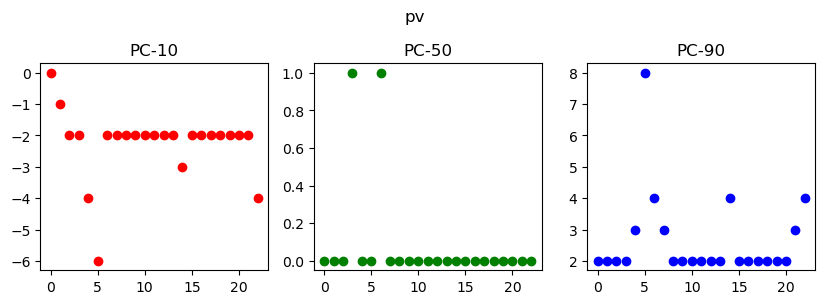

In [24]:
import matplotlib.pyplot as plt 

plot_percentile(band, 1, prc_10, prc_50, prc_90)

In [12]:
def plot_percentile(band, n, prc_10, prc_50, prc_90):
    plt.figure(figsize=(10, 3))

    x_values = np.arange(len(prc_10))
    plt.subplot(n, 3, 1)
    plt.plot(x_values, prc_10, 'ro', label=f'PC-10 {band}')
    plt.title('PC-10')

    x_values = np.arange(len(prc_50))
    plt.subplot(n, 3, 2)
    plt.plot(x_values, prc_50, 'go', label=f'PC-50 {band}')
    plt.title('PC-50')

    x_values = np.arange(len(prc_90))
    plt.subplot(n, 3, 3)
    plt.plot(x_values, prc_90, 'bo', label=f'PC-90 {band}')    
    plt.title('PC-90')    
    plt.subplots_adjust(top=0.8)
    
    plt.suptitle(f'{band}')
    # plt.savefig(f'{a[0]}_PV.png')

    plt.show()
    

In [29]:
pv = [0.8173, 0.60782, 0.28582, 0.45285, -0.39974, 0.53956, 0.87425, 0.2766, -0.26428, -0.0342, 0.20915,
      0.1353, 0.24652, 0.28773, 0.41996, 0.06153,   0.1809, 0.24718, 0.09157, 0.21605, 0.21477, 0.35284, 0.04373]

npv = [-0.93897, -1.52596, -0.96896, -1.86277, -1.59307, -4.83937, -4.33097, -4.91903, -4.65783, -4.27846, -3.90202, -3.5853,
        -2.6185, -2.3059, -2.55879, -0.12509,   0.26657, -0.35335, -0.34228, -0.11394, -0.1609, -0.03855, 0.79534]

bs = [0.16232, 0.94712, 0.9176, 1.39604, 1.98836, 4.26565, 3.40161, 4.57568, 4.85792, 4.28592, 3.66944, 3.38111, 2.32073,
      1.98586, 2.12615, 0.06166, -0.44729, 0.10343, 0.24836, -0.09738, -0.05134, -0.31139, -0.81951] 

len(pv), len(npv), len(bs)

print("PV min:", np.min(pv), "max:", np.max(pv))
print("NPV min:", np.min(npv), "max:", np.max(npv)) 
print("BS min:", np.min(bs), "max:", np.max(bs)) 


PV min: -0.39974 max: 0.87425
NPV min: -4.91903 max: 0.79534
BS min: -0.81951 max: 4.85792


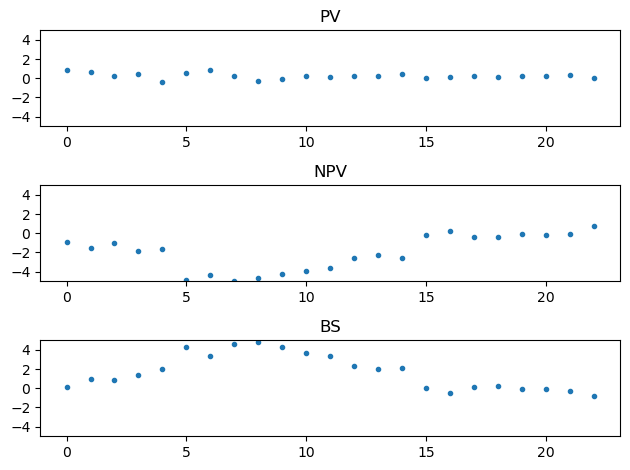

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot(label, band, plt_x):
    plt_x.plot(np.arange(len(band)), band, 'o', markersize=3) 
    plt_x.set_title(label)
    plt_x.set_yticks(np.arange(-6, 6, 2))
    plt.ylim(-5, 5) 
    
plt_x = plt.subplot(3, 1, 1)
plot("PV", pv, plt_x)        

plt_x = plt.subplot(3, 1, 2)
plot("NPV", npv, plt_x) 

plt_x = plt.subplot(3, 1, 3)
plot("BS", bs, plt_x) 

plt.tight_layout()